In [20]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from src.models import Encoder, Decoder, ClusteringLayer
from src.metrics.similarity import euclidean_distance
from src.datasets import PolynomialDataset
from torch.utils.data import DataLoader


In [2]:
run = wandb.init(project="DTC", name='test')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tristanbester1. Use `wandb login --relogin` to force relogin


In [3]:
encoder_artifact = run.use_artifact('tristanbester1/DTC/encoder-1fc4eti3:v0', type='model')
decoder_artifact = run.use_artifact('tristanbester1/DTC/decoder-1fc4eti3:v0', type='model')
cl_artifact = run.use_artifact('tristanbester1/DTC/CL-1fc4eti3:v0', type='model')

encoder_dir = encoder_artifact.download()
decoder_dir = decoder_artifact.download()
cl_dir = cl_artifact.download()

In [6]:
ENCODER_CONFIG = {
    "input_dim": 1,
    "seq_len": 100,
    "cnn_kernel": 10,
    "cnn_stride": 2,
    "mp_kernel": 4,
    "mp_stride": 2,
    "lstm_hidden_dim": 1,
}

DECODER_CONFIG = {
    "seq_len": 100,
    "cnn_kernel": 10,
    "cnn_stride": 2,
    "mp_kernel": 4,
    "mp_stride": 2,
    "upsample_scale": 2,
    "input_dim": 1,
    "hidden_dim": 1,
    "deconv_kernel": 14,
    "deconv_stride": 2,
}

In [13]:
encoder =  Encoder(**ENCODER_CONFIG)
decoder = Decoder(**DECODER_CONFIG)
cluster = ClusteringLayer(torch.rand((3,22,1)), euclidean_distance, 1)

In [14]:
encoder.load_state_dict(torch.load('artifacts/encoder-1fc4eti3:v0/model_encoder.pt'))
decoder.load_state_dict(torch.load('artifacts/decoder-1fc4eti3:v0/model_decoder.pt'))
cluster.load_state_dict(torch.load('artifacts/CL-1fc4eti3:v0/model_cluster.pt'))

<All keys matched successfully>

In [59]:
dataset = PolynomialDataset(
    X_path='artifacts/polynomial_dataset_X:v0',
    Y_path='artifacts/polynomial_dataset_Y:v0'
)
data_loader = DataLoader(dataset, batch_size=1)

In [32]:
x_lin, _ = dataset[0]
x_quad, _ = dataset[100]
x_cubic, _ = dataset[200]

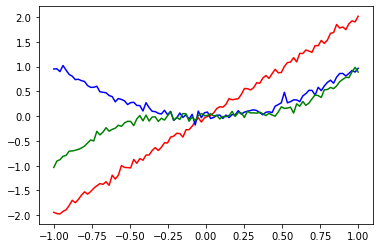

In [37]:
plt.plot(np.linspace(-1,1,100), x_lin, c='r')
plt.plot(np.linspace(-1,1,100), x_quad, c='b')
plt.plot(np.linspace(-1,1,100), x_cubic, c='g')

plt.show()

In [35]:
l_lin = encoder(x_lin.unsqueeze(0))[0].detach().numpy()
l_quad = encoder(x_quad.unsqueeze(0))[0].detach().numpy()
l_cubic = encoder(x_cubic.unsqueeze(0))[0].detach().numpy()

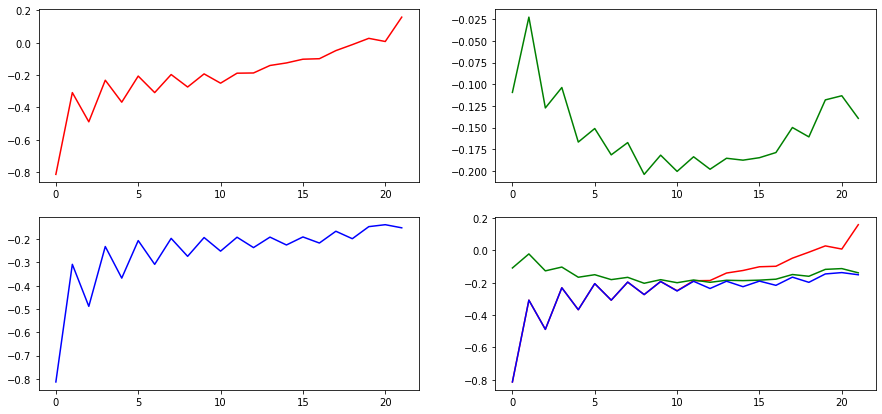

In [43]:
fig, ax = plt.subplots(2, 2)

ax[0][0].plot(range(len(l_lin)), l_lin, c='r')

ax[0][1].plot(range(len(l_quad)), l_quad, c='g')

ax[1][0].plot(range(len(l_cubic)), l_cubic, c='b')

ax[1][1].plot(range(len(l_lin)), l_lin, c='r')
ax[1][1].plot(range(len(l_quad)), l_quad, c='g')
ax[1][1].plot(range(len(l_cubic)), l_cubic, c='b')

fig.set_size_inches(15, 7)
plt.show()

* Network probably combining all quadratic and linear functions into same cluster
* May be worse than this though

In [46]:
l_lin = encoder(x_lin.unsqueeze(0))[0].detach()
l_quad = encoder(x_quad.unsqueeze(0))[0].detach()
l_cubic = encoder(x_cubic.unsqueeze(0))[0].detach()

In [47]:
cluster(l_lin.unsqueeze(0))

tensor([[0.3396, 0.3243, 0.3360]], grad_fn=<DivBackward0>)

In [48]:
cluster(l_quad.unsqueeze(0))

tensor([[0.3418, 0.3241, 0.3341]], grad_fn=<DivBackward0>)

In [56]:
c_1 = cluster.centroids[0].detach().numpy()
c_2 = cluster.centroids[1].detach().numpy()
c_3 = cluster.centroids[2].detach().numpy()

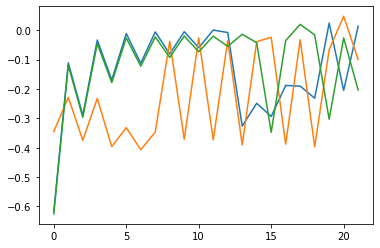

In [57]:
plt.plot(range(len(l_lin)), c_1)
plt.plot(range(len(l_lin)), c_2)
plt.plot(range(len(l_lin)), c_3)

plt.show()

### Calculating initial cluster centroids

In [66]:
latent = []

for x, _ in data_loader:
    l = encoder(x).detach()
    latent.append(l)
latent = torch.cat(latent)

In [67]:
latent.shape

torch.Size([300, 22, 1])

In [68]:
similarity_matrix = euclidean_distance(latent, latent)

clustering_assignments = AgglomerativeClustering(
    n_clusters=3, affinity="precomputed", linkage="complete",
).fit_predict(similarity_matrix)

centroids = []
for i in np.unique(clustering_assignments):
    centroid = latent[clustering_assignments == i].mean(dim=0).unsqueeze(0)
    centroids.append(centroid)
centroids = torch.cat(centroids)

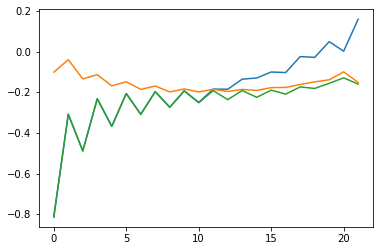

In [71]:
plt.plot(range(len(l_lin)), centroids[0])
plt.plot(range(len(l_lin)), centroids[1])
plt.plot(range(len(l_lin)), centroids[2])

plt.show()

In [72]:
cluster2 = ClusteringLayer(centroids, euclidean_distance, 1)

In [74]:
cluster2(l_lin.unsqueeze(0))

tensor([[0.4496, 0.2352, 0.3152]], grad_fn=<DivBackward0>)

### All latent

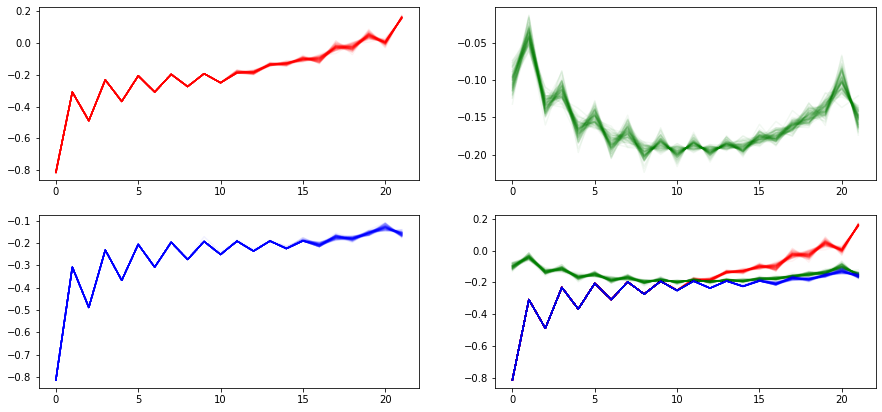

In [80]:
fig, ax = plt.subplots(2, 2)

for x, y in data_loader:
    latent = encoder(x).squeeze(0).detach().numpy()

    if y[0] == 0:
        ax[0][0].plot(range(len(latent)), latent, c='r', alpha=0.05)
        ax[1][1].plot(range(len(latent)), latent, c='r', alpha=0.05)
    elif y[0] == 1:
        ax[0][1].plot(range(len(latent)), latent, c='g', alpha=0.05)
        ax[1][1].plot(range(len(latent)), latent, c='g', alpha=0.05)
    else:
        ax[1][0].plot(range(len(latent)), latent, c='b', alpha=0.05)
        ax[1][1].plot(range(len(latent)), latent, c='b', alpha=0.05)
        
fig.set_size_inches(15, 7)
plt.show()

### All latent with initial cluster centroids

In [ ]:
latent = []

for x, _ in data_loader:
    l = encoder(x).detach()
    latent.append(l)
latent = torch.cat(latent)

similarity_matrix = euclidean_distance(latent, latent)

clustering_assignments = AgglomerativeClustering(
    n_clusters=3, affinity="precomputed", linkage="complete",
).fit_predict(similarity_matrix)

centroids = []
for i in np.unique(clustering_assignments):
    centroid = latent[clustering_assignments == i].mean(dim=0).unsqueeze(0)
    centroids.append(centroid)
centroids = torch.cat(centroids)

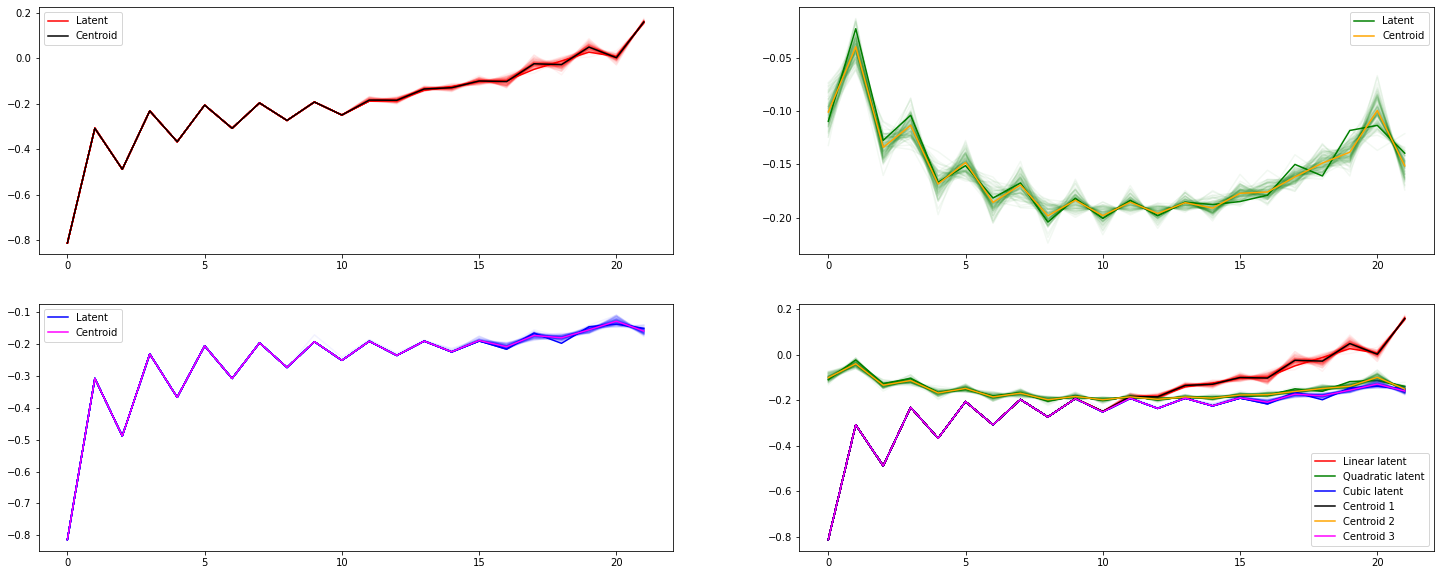

In [91]:
fig, ax = plt.subplots(2, 2)

labelled_one = False 
labelled_two = False 
labelled_three = False

for x, y in data_loader:
    latent = encoder(x).squeeze(0).detach().numpy()

    if y[0] == 0:
        if not labelled_one:
            ax[0][0].plot(range(len(latent)), latent, c='r', label='Latent')
            ax[1][1].plot(range(len(latent)), latent, c='r', label='Linear latent')
        else:
            ax[0][0].plot(range(len(latent)), latent, c='r', alpha=0.05) 
            ax[1][1].plot(range(len(latent)), latent, c='r', alpha=0.05)
        labelled_one = True
    elif y[0] == 1:
        if not labelled_two:
            ax[0][1].plot(range(len(latent)), latent, c='g', label='Latent')
            ax[1][1].plot(range(len(latent)), latent, c='g', label='Quadratic latent')
        else:
            ax[0][1].plot(range(len(latent)), latent, c='g', alpha=0.05)
            ax[1][1].plot(range(len(latent)), latent, c='g', alpha=0.05)
        labelled_two = True
    else:
        if not labelled_three:
            ax[1][0].plot(range(len(latent)), latent, c='b', label="Latent")
            ax[1][1].plot(range(len(latent)), latent, c='b', label='Cubic latent')
        else:
            ax[1][0].plot(range(len(latent)), latent, c='b', alpha=0.05)
            ax[1][1].plot(range(len(latent)), latent, c='b', alpha=0.05)
        labelled_three = True


ax[0][0].plot(range(len(centroid[0])), centroids[0], c='black', label='Centroid')
ax[0][1].plot(range(len(centroid[0])), centroids[1], c='orange', label='Centroid')
ax[1][0].plot(range(len(centroid[0])), centroids[2], c='fuchsia', label='Centroid')

ax[1][1].plot(range(len(centroid[0])), centroids[0], c='black', label='Centroid 1')
ax[1][1].plot(range(len(centroid[0])), centroids[1], c='orange', label='Centroid 2')
ax[1][1].plot(range(len(centroid[0])), centroids[2], c='fuchsia', label='Centroid 3')

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
        
fig.set_size_inches(25, 10)
plt.show()

### All latent with optimised centroids

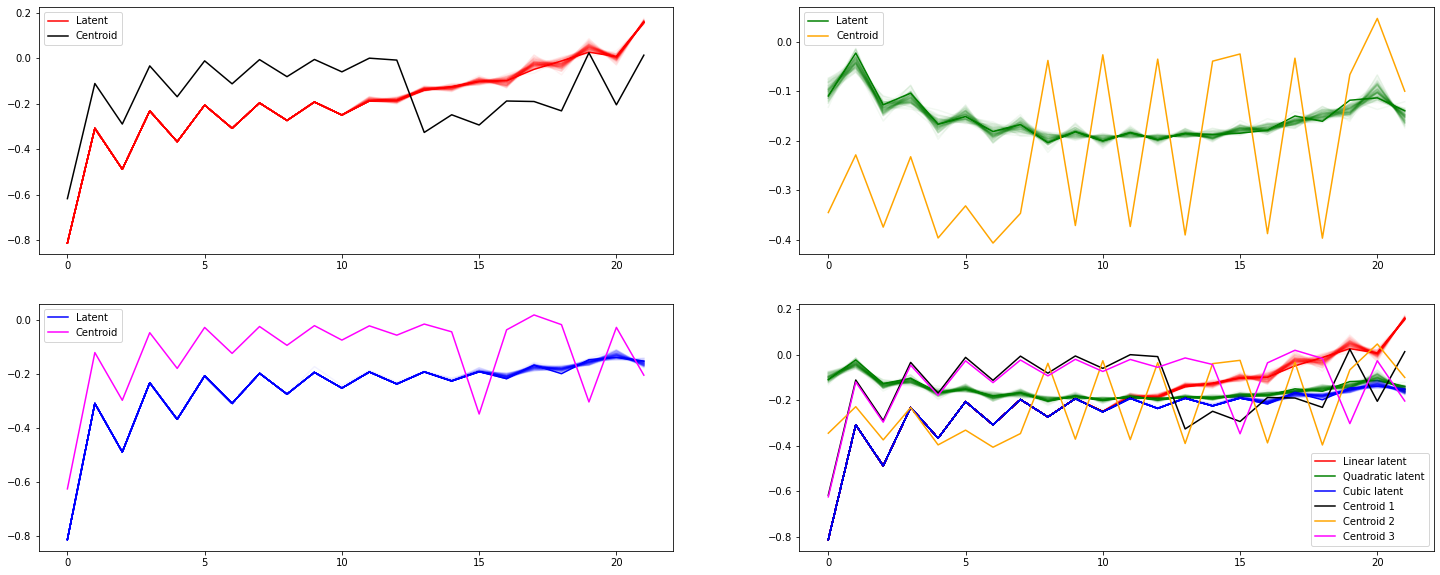

In [95]:
fig, ax = plt.subplots(2, 2)

labelled_one = False 
labelled_two = False 
labelled_three = False

for x, y in data_loader:
    latent = encoder(x).squeeze(0).detach().numpy()

    if y[0] == 0:
        if not labelled_one:
            ax[0][0].plot(range(len(latent)), latent, c='r', label='Latent')
            ax[1][1].plot(range(len(latent)), latent, c='r', label='Linear latent')
        else:
            ax[0][0].plot(range(len(latent)), latent, c='r', alpha=0.05) 
            ax[1][1].plot(range(len(latent)), latent, c='r', alpha=0.05)
        labelled_one = True
    elif y[0] == 1:
        if not labelled_two:
            ax[0][1].plot(range(len(latent)), latent, c='g', label='Latent')
            ax[1][1].plot(range(len(latent)), latent, c='g', label='Quadratic latent')
        else:
            ax[0][1].plot(range(len(latent)), latent, c='g', alpha=0.05)
            ax[1][1].plot(range(len(latent)), latent, c='g', alpha=0.05)
        labelled_two = True
    else:
        if not labelled_three:
            ax[1][0].plot(range(len(latent)), latent, c='b', label="Latent")
            ax[1][1].plot(range(len(latent)), latent, c='b', label='Cubic latent')
        else:
            ax[1][0].plot(range(len(latent)), latent, c='b', alpha=0.05)
            ax[1][1].plot(range(len(latent)), latent, c='b', alpha=0.05)
        labelled_three = True


ax[0][0].plot(range(len(centroid[0])), cluster.centroids[0].detach().numpy(), c='black', label='Centroid')
ax[0][1].plot(range(len(centroid[0])), cluster.centroids[1].detach().numpy(), c='orange', label='Centroid')
ax[1][0].plot(range(len(centroid[0])), cluster.centroids[2].detach().numpy(), c='fuchsia', label='Centroid')

ax[1][1].plot(range(len(centroid[0])), cluster.centroids[0].detach().numpy(), c='black', label='Centroid 1')
ax[1][1].plot(range(len(centroid[0])), cluster.centroids[1].detach().numpy(), c='orange', label='Centroid 2')
ax[1][1].plot(range(len(centroid[0])), cluster.centroids[2].detach().numpy(), c='fuchsia', label='Centroid 3')

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
        
fig.set_size_inches(25, 10)
plt.show()

### Prediction tests

In [98]:
l = encoder(x_lin.unsqueeze(0))
cluster2(l).argmax(dim=1)

tensor([0])

### question - How does target distribution compare to what we actually want>?????
* Cross entropy between Q and Label vs P and label
* Think if what we expect for this problem aligns with what the optimisation problem is actually trying to do.

In [109]:
x = torch.tensor([[0,1,2],[0,1,2], [0,1,2], [0,1,2]])

In [110]:
x

tensor([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]])

In [114]:
torch.cat([x[:, 0], x[:, 2], x[:, 1]]).reshape(3, 4).T

tensor([[0, 2, 1],
        [0, 2, 1],
        [0, 2, 1],
        [0, 2, 1]])

In [158]:
import pickle
import numpy as np

In [159]:
with open('centroids.pkl', 'rb') as f:
    centroids = pickle.load(f)

In [160]:
x = np.array([i.squeeze(-1) for i in centroids])

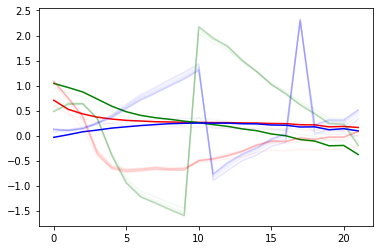

In [161]:
for i in range(11):
    for j in range(3):
        if i == 0:
            if j == 0:
                plt.plot(range(x[i][j].shape[0]), x[i][j], c='r')
            elif j == 1:
                plt.plot(range(x[i][j].shape[0]), x[i][j], c='g')
            else:
                plt.plot(range(x[i][j].shape[0]), x[i][j], c='b')
        else:
            if j == 0:
                plt.plot(range(x[i][j].shape[0]), x[i][j], alpha=0.05, c='r')
            elif j == 1:
                plt.plot(range(x[i][j].shape[0]), x[i][j], alpha=0.05, c='g')
            else:
                plt.plot(range(x[i][j].shape[0]), x[i][j], alpha=0.05, c='b')

plt.show()

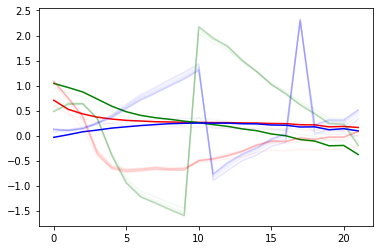

In [162]:
for i in range(11):
    for j in range(3):
        if i == 0:
            if j == 0:
                plt.plot(range(x[i][j].shape[0]), x[i][j], c='r')
            elif j == 1:
                plt.plot(range(x[i][j].shape[0]), x[i][j], c='g')
            else:
                plt.plot(range(x[i][j].shape[0]), x[i][j], c='b')
        else:
            if j == 0:
                plt.plot(range(x[i][j].shape[0]), x[i][j], alpha=0.05, c='r')
            elif j == 1:
                plt.plot(range(x[i][j].shape[0]), x[i][j], alpha=0.05, c='g')
            else:
                plt.plot(range(x[i][j].shape[0]), x[i][j], alpha=0.05, c='b')

plt.show()

In [163]:
x[0].shape

(3, 22)

In [164]:
with open('preds.pkl', 'rb') as f:
    p = pickle.load(f)

In [165]:
l, y = p[0]

In [166]:
l = l.squeeze(-1).detach().numpy()

In [167]:
y = y.squeeze(1).detach().numpy()

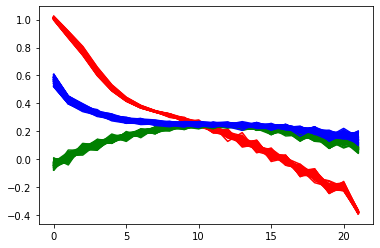

In [168]:



for i in range(y.shape[0]):
    if y[i] == 0:
        plt.plot(range(len(l[i])), l[i], c='r')
    elif y[i] == 1:
        plt.plot(range(len(l[i])), l[i], c='g')
    else:
        plt.plot(range(len(l[i])), l[i], c='b')


In [169]:
y.shape

(300, 1)

In [170]:
with open('preds.pkl', 'rb') as f:
    p = pickle.load(f)

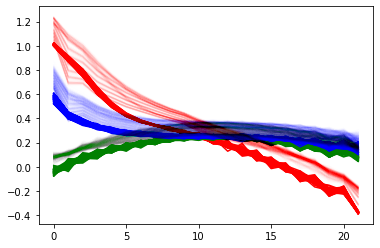

In [171]:
for i, (l, y) in enumerate(p):
    l = l.squeeze(-1).detach().numpy()
    y = y.squeeze(1).detach().numpy()

    for j in range(y.shape[0]):
        if i == 0:
            if y[j] == 0:
                plt.plot(range(len(l[j])), l[j], c='r')
            elif y[j] == 1:
                plt.plot(range(len(l[j])), l[j], c='g')
            else:
                plt.plot(range(len(l[j])), l[j], c='b')
        else:
            if y[j] == 0:
                plt.plot(range(len(l[j])), l[j], alpha=0.005, c='r')
            elif y[j] == 1:
                plt.plot(range(len(l[j])), l[j], alpha=0.005, c='g')
            else:
                plt.plot(range(len(l[j])), l[j], alpha=0.005, c='b')
    
plt.show()